In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error

In [ ]:
train_for = 735
predict_for = 14

In [ ]:
def smoothen_freq(df):
  x = df
  nan_indices = np.isnan(x)

  # # Remove the NaN values from the array
  x = x[np.logical_not(nan_indices)]

  # Generate a noisy signal
  signal = x

  # Apply Fourier transform to the signal
  f_signal = np.fft.fft(signal)

  # Calculate the power spectrum
  power = np.abs(f_signal)**2

  # Set a threshold to remove the noise
  threshold = 0.005 * max(power)
  f_signal[power < threshold] = 0

  # Apply inverse Fourier transform to the filtered signal
  filtered_signal = np.fft.ifft(f_signal)

  return filtered_signal


In [ ]:
look_back = 50

def prepare_data(df):
    X = []
    y = []
    for i in range(look_back, len(df)):
        y.append(df[i])
        X.append(df[i - look_back:i])
    return np.array(X), np.array(y)

In [ ]:
def scale(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.fit_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

def descaled(df, scaler):
  simple_array = np.array(df).reshape(-1, 1)
  ssimple_array = scaler.inverse_transform(simple_array)
  return np.array(ssimple_array).reshape((-1, ))

In [ ]:
class Model:
  def __init__(self, df):
    self.model=None
    self.scaler = MinMaxScaler()
    # self.df = smoothen_freq(df)
    self.df = scale(df, self.scaler)
    self.dfw, self.dfy = prepare_data(self.df)

    model_strong = tf.keras.Sequential([
        LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)),
        LSTM(units = 32, return_sequences=True),
        LSTM(units = 32),
        Dense(units = 32)
    ])
    
    model_weak=tf.keras.Sequential([
        LSTM(units = 32, return_sequences=True, input_shape = (self.dfw.shape[1], 1)),
        Dropout(0.2),
        LSTM(units = 32, return_sequences=True),
        Dropout(0.2),
        LSTM(units = 32),
        Dropout(0.2),
        Dense(units = 32)
    ])

    concatenated=tf.keras.layers.Concatenate()([model_strong.output, model_weak.output])
    l1=tf.keras.layers.Dense(64)(concatenated)
    l2=tf.keras.layers.Dense(32)(l1)
    l3=tf.keras.layers.Dense(16)(l2)
    l4=tf.keras.layers.Dense(1)(l3)


    

    self.model=tf.keras.Model(inputs=[model_strong.input, model_weak.input], outputs=l4)
    self.model.compile(optimizer = 'adam', loss = "mean_squared_error")

    

  def fit(self):
    y_train = self.dfy 
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    self.model.fit([self.dfw, self.dfw], y_train, epochs = 100, callbacks=[callback])
  
  def predict(self, predict_for):
    df_full = self.dfw[-1]

    X_p = [df_full]
    y_p = []

    for i in range(predict_for):
        yi = self.model.predict([np.array(X_p), np.array(X_p)])
        y_p.append(yi[0][0])
        
        X_p = [np.append(X_p[0][1:], yi)]

    return descaled(y_p, self.scaler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/covid-final-all.csv')
df['state_residence'] = df.apply(lambda row: row['state_residence'].lower(), axis=1)
print(df.columns)
print(df.state_residence.unique())

df=df.groupby(['Date']).agg({'<15_pos': 'sum', '15-24_pos': 'sum', '25-34_pos':'sum', '35-44_pos':'sum', '45-59_pos':'sum', '60-80_pos':'sum', '>80_pos':'sum', 'new_case': 'sum'}).reset_index()
df.head()


date = df.iloc[train_for + 1]['Date']


df_total = df['new_case'].values

# df_total = df['new_case']

# n = 70  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# df_total = lfilter(b, a, df_total)
# df_total = smoothen(df_total, 10)

Index(['Unnamed: 0', 'state_residence', 'district_residence', 'Date', '<15',
       '15-24', '25-34', '35-44', '45-59', '60-80', '>80', '<15_pos',
       '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos',
       '>80_pos', 'M_pos', '2', 'F_pos', 'T', 'F', 'M', 'NIA', 'T_pos',
       'NIA_pos', 'O', 'O_pos', 'N', 'G', ',', 'D', 'new_case',
       'negative_case', 'Failed_test', 'Total_test',
       'negative_egene_screening', 'positive_egene_screening',
       'Failed_test_egene_screening', '<20_ct_value_screening',
       '20-30_ct_value_screening', '31-35_ct_value_screening',
       '>35_ct_value_screening', '<20_posct_value_screening',
       '20-30_posct_value_screening', '31-35_posct_value_screening',
       '>35_posct_value_screening', 'negative_rdrp_confirmatory',
       'positive_rdrp_confirmatory', 'Failed_test_rdrp_confirmatory',
       '<20_ct_value_rdrp', '20-30_ct_value_rdrp', '31-35_ct_value_rdrp',
       '>35_ct_value_rdrp', '<20_posct_value_rdrp', '20-30_po

In [ ]:
age_groups = ['<15_pos', '15-24_pos', '25-34_pos', '35-44_pos', '45-59_pos', '60-80_pos', '>80_pos']

df_age_wise = {}

for age_group in age_groups:
  df_age_wise[age_group] = df[age_group].values

models = {}
for age_group in age_groups:
  models[age_group] = Model(df_age_wise[age_group][:train_for])

In [ ]:
counter = 0
for age_group in age_groups:
  print('*************************************************************')
  print(counter, "/", len(age_groups))
  print('*************************************************************')
  counter += 1
  models[age_group].fit()

*************************************************************
0 / 7
*************************************************************
Epoch 1/100
22/22 [==============================] - 21s 228ms/step - loss: 0.0122
Epoch 2/100
22/22 [==============================] - 3s 120ms/step - loss: 0.0057
Epoch 3/100
22/22 [==============================] - 3s 127ms/step - loss: 0.0037
Epoch 4/100
22/22 [==============================] - 3s 127ms/step - loss: 0.0041
Epoch 5/100
22/22 [==============================] - 3s 155ms/step - loss: 0.0038
Epoch 6/100
22/22 [==============================] - 4s 195ms/step - loss: 0.0041
Epoch 7/100
22/22 [==============================] - 3s 127ms/step - loss: 0.0037
Epoch 8/100
22/22 [==============================] - 3s 132ms/step - loss: 0.0039
*************************************************************
1 / 7
*************************************************************
Epoch 1/100
22/22 [==============================] - 19s 158ms/step - loss: 0.0000e

In [ ]:
predictions = models[age_groups[0]].predict(predict_for)

for i in range(1, len(age_groups)):
  predictions = predictions + models[age_groups[i]].predict(predict_for)

1/1 [==============================] - 0s 49ms/step


In [ ]:
def mape_(p, a):
  print(len(p))
  print(len(a))
  m = 0.0
  for i in range(len(p)):
    m += abs(p[i] - a[i]) / a[i]
  return( m / len(p)) * 100

In [ ]:
actual = df_total[train_for:train_for+predict_for]

MAPE = mape_(predictions, actual)
print("MAPE:", MAPE)

14
14
MAPE: 53.972733283325084


In [ ]:
import matplotlib.pyplot as plt
def append(a, b):
  c = []
  for ai in a:
    c.append(ai)
  for bi in b:
    c.append(bi)
  return c

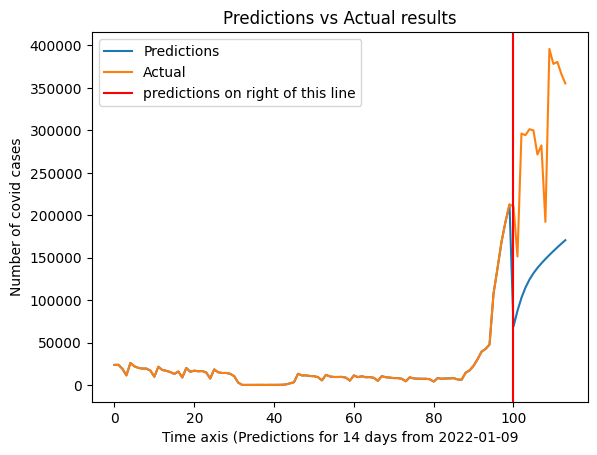

In [ ]:
window = 100
plt.figure()
plt.title("Predictions vs Actual results")
plt.plot(append(df_total[train_for - window:train_for], predictions), label="Predictions")
plt.plot(append(df_total[train_for - window:train_for], actual), label="Actual")
plt.xlabel("Time axis (Predictions for 14 days from " + date)
plt.ylabel("Number of covid cases")
plt.axvline(window, color = 'red', label = "predictions on right of this line")
plt.legend()
plt.show()

In [ ]:
print(predictions)

[ 68800.53   87383.33  102744.09  114792.266 124161.2   131628.55
 137864.42  143351.56  148396.92  153173.3   157763.9   162198.7
 166478.52  170594.27 ]


In [ ]:
print(actual)

[210776. 151381. 296176. 294335. 301381. 299917. 271532. 282287. 192190.
 395946. 378298. 380601. 366328. 355255.]


In [ ]:
counter = 0
for age_group in age_groups:
  print('*************************************************************')
  print(counter, "/", len(age_groups))
  print('*************************************************************')
  counter += 1
  models[age_group].model.save("model_" + age_group + date + ".h5")

*************************************************************
0 / 7
*************************************************************
*************************************************************
1 / 7
*************************************************************
*************************************************************
2 / 7
*************************************************************
*************************************************************
3 / 7
*************************************************************
*************************************************************
4 / 7
*************************************************************
*************************************************************
5 / 7
*************************************************************
*************************************************************
6 / 7
*************************************************************
